In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [2]:
from bliss import sleep
from bliss.datasets import simulated

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [6]:
with initialize(config_path="../../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [7]:
cfg.model.decoder.kwargs.update({'n_bands': 1, 
                             'slen': 300, 
                             'tile_slen': 10, 
                             'ptile_slen': 30, 
                             'border_padding': 5, 
                             'mean_sources': 0.5,
                             'background_values': [680], 
                             'psf_params_file': './zband_psf_simple.npy'})

cfg.model.encoder.kwargs.update({'ptile_slen': 20})

cfg.dataset.kwargs.update({'n_batches': 1, 'batch_size': 1})


In [8]:
model_filename = './fits/tmp'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [9]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [10]:
border_padding = sleep_net.image_encoder.border_padding

# load data

In [11]:
# from astropy.io import fits
# hdul = fits.open('../../../../decaps/data/decaps_l0_b0_hdu08_z')

# image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

# slen = 300
# x0 = 20
# x1 = 20

In [37]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)
out = dataset.get_batch()
image = out['images']

slen = 300
x0 = border_padding
x1 = border_padding

In [38]:
test_image = plotting.crop_image(image, 
                                 x0 - border_padding, 
                                 x1 - border_padding,
                                 slen + 2 * border_padding,
                                 slen + 2 * border_padding)

In [39]:
test_image.shape

torch.Size([1, 1, 310, 310])

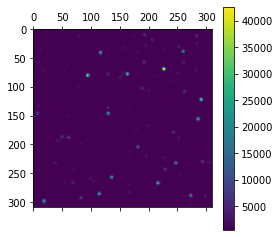

In [40]:
plt.matshow(test_image.cpu().numpy()[0, 0])
plt.colorbar()

In [41]:
np.arange(10)[0:8:2]

array([0, 2, 4, 6])

In [42]:
tmp = test_image[0, 0]

In [43]:
s = 4
out = tmp[0:tmp.shape[0]:s][:, 0:tmp.shape[0]:s]

(array([5.944e+03, 6.200e+01, 2.400e+01, 9.000e+00, 1.000e+01, 7.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 5.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  586.05865,  1726.6539 ,  2867.2493 ,  4007.8445 ,  5148.44   ,
         6289.035  ,  7429.6304 ,  8570.226  ,  9710.821  , 10851.416  ,
        11992.012  , 13132.607  , 14273.202  , 15413.798  , 16554.393  ,
        17694.988  , 18835.584  , 19976.18   , 21116.773  , 22257.37   ,
        23397.965  , 24538.56   , 25679.156  , 26819.75   , 27960.346  ,
        29100.941  , 30241.537  , 31382.133  , 32522.727  , 33663.324  ,
        34803.918  ], dtype=float32),
 <BarContainer object of 30 artists>)

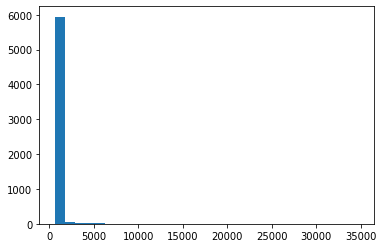

In [44]:
plt.hist(out.flatten().cpu().numpy(), bins = 30)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5610139b20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f55cf111280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5610139790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f55cf1119a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f55cf111d30>],
 'means': []}

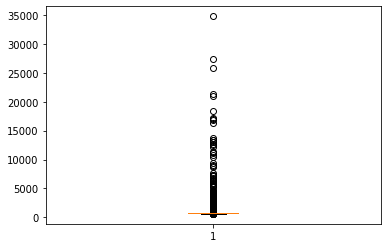

In [45]:
plt.boxplot(out.flatten().cpu().numpy())

In [46]:
np.median(out.cpu())

689.8603

# Get starnet map estimates

In [47]:
map_estimate = sleep_net.image_encoder.map_estimate(test_image.to(device), slen)


# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

### Check the coverage

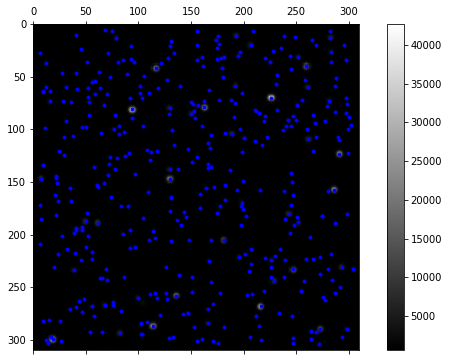

In [48]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='.',
        color='b', 
    )

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

In [49]:
map_estimate['locs']

tensor([[ 11.1934,  41.1577],
        [  6.1710,  68.9211],
        [  6.6857,  75.5631],
        [ 13.3027,  79.2754],
        [  7.4204, 155.9059],
        [ 12.0058, 176.0786],
        [ 11.4098, 193.2487],
        [  7.2964, 209.4993],
        [ 12.1602, 238.5429],
        [ 12.8562, 249.6911],
        [  6.7436, 282.4698],
        [ 13.2213, 283.0246],
        [ 24.5079,  45.5825],
        [ 21.4306,  93.8940],
        [ 16.2554, 131.6161],
        [ 20.9142, 130.1030],
        [ 20.6812, 155.9224],
        [ 15.7871, 174.2100],
        [ 19.5440, 176.8042],
        [ 22.9988, 175.3291],
        [ 20.4601, 207.0539],
        [ 23.0270, 236.2943],
        [ 15.8345, 265.7300],
        [ 20.4727, 269.5486],
        [ 19.8765, 296.0333],
        [ 28.3465,   7.0592],
        [ 28.1164,  71.4195],
        [ 33.7164,  93.3181],
        [ 34.6718,  86.2675],
        [ 28.3537, 133.9576],
        [ 33.0780, 128.2207],
        [ 32.1659, 160.9187],
        [ 34.3987, 156.5132],
        [ 

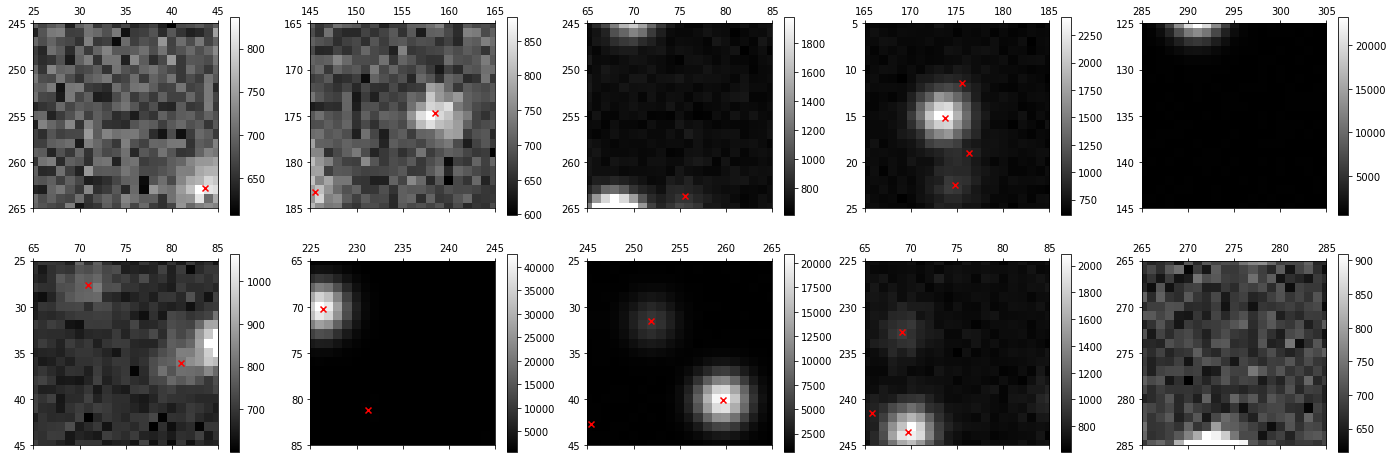

In [60]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 20
x0_vec = np.arange(x0, x0 + slen, subimage_slen)
x1_vec = np.arange(x1, x1 + slen, subimage_slen)

for i in range(10): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)